In [99]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon
import matplotlib.cm as cm  # Importar módulo de colormap
from Quad9 import Quad9
from Node import Node
from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa
from fem import Material
from Membrane import Membrane
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace

In [100]:
output_file = "mallas/malla_quad9.msh"   #cambiar el numero de la malla --> malla_quad4G1.msh, malla_quad4G2.msh, malla_quad4G3.msh, malla_quad4G4.msh, malla_quad4L1.msh,....
titulo = "Quad 4 Local refinement case 4"#"Quad 9 Global refinement case 1" #Cambiar el numero y G-->L

In [101]:
import meshio
import numpy as np
from collections import defaultdict
from Node import Node  # Asegúrate que Node tenga `.index`, `.coord`, `.restrain` y `plot_nodes_por_grupo`

def make_nodes_groups_quad9(output_file, title):
    mesh = meshio.read(output_file)
    
    tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}
    grupos = defaultdict(dict)  # nombre_grupo: {id_nodo: Node}

    # Procesar elementos tipo quad9
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "quad9":
            continue
        for quad, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in quad:
                x, y = mesh.points[node_id][:2]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y])

    # Procesar líneas tipo line3 para condiciones de borde
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "line3":
            continue
        for line, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, str(tag))
            for node_id in line:
                x, y = mesh.points[node_id][:2]
                restrain = [0, 0]
                if nombre == "BC_R1":
                    restrain = [1, 1]
                if node_id not in grupos[nombre]:
                    grupos[nombre][node_id] = Node(node_id + 1, [x, y], restrain=restrain)

                else:
                    grupos[nombre][node_id].restrain = restrain  # Actualiza si ya existe

    # Convertir a listas
    grupos_final = {nombre: list(nodos.values()) for nombre, nodos in grupos.items()}

    return grupos_final, mesh

grupos, mesh = make_nodes_groups_quad9(output_file, "Quad9")

In [102]:


class Membrane:
    def __init__(self, thickness, material):
        self.thickness = thickness
        self.material = material

def make_sections(grupos):
    thickness_dict = {"201": 100, "202":100}
    sections = {}

    for group in thickness_dict:
        material = Material.Material(E=200e3, nu=0.36, gamma=7800e-9)
        sections[group] = Membrane(thickness_dict[group], material)

    nodes_dict = {}
    for group in grupos:
        for node in grupos[group]:
            nodes_dict[node.index] = node

    return sections, nodes_dict

sections, nodes_dict = make_sections(grupos)


In [103]:
# Extrae el primer elemento tipo quad9
nodes_mesh = mesh.cells_dict['quad9'][0]

print("Nodos del primer Quad9:")
for i, node_id in enumerate(nodes_mesh):
    global_id = node_id + 1  # Node usa índices base 1
    coord = nodes_dict[global_id].coord
    print(f"  Nodo local {i}: ID global {global_id}, coordenadas = {coord}")

Nodos del primer Quad9:
  Nodo local 0: ID global 1, coordenadas = [np.float64(0.0), np.float64(200.0)]
  Nodo local 1: ID global 10, coordenadas = [np.float64(22.22222222222219), np.float64(177.7777777777778)]
  Nodo local 2: ID global 214, coordenadas = [np.float64(86.41975308641963), np.float64(177.7777777777778)]
  Nodo local 3: ID global 163, coordenadas = [np.float64(66.66666666666666), np.float64(200.0)]
  Nodo local 4: ID global 18, coordenadas = [np.float64(11.11111111111109), np.float64(188.8888888888889)]
  Nodo local 5: ID global 278, coordenadas = [np.float64(54.3209876543209), np.float64(177.7777777777778)]
  Nodo local 6: ID global 279, coordenadas = [np.float64(76.54320987654313), np.float64(188.8888888888889)]
  Nodo local 7: ID global 171, coordenadas = [np.float64(33.33333333333333), np.float64(200.0)]
  Nodo local 8: ID global 280, coordenadas = [np.float64(43.82716049382708), np.float64(188.8888888888889)]


In [104]:
def make_quad9_elements(mesh, sections, nodes_dict):
    quads = mesh.cells_dict.get('quad9', [])
    tags = mesh.cell_data_dict["gmsh:physical"].get("quad9", [])
    elements = []
    used_nodes = set()
    nodos_faltantes = []
    errores_jacobiano = []

    for i in range(len(tags)):
        section_tag = str(tags[i])
        if section_tag not in sections:
            print(f"⚠️ Tag físico {section_tag} no tiene sección asociada. Elemento {i + 1} omitido.")
            continue

        section = sections[section_tag]
        node_ids = quads[i]

        try:
            nodos = [nodes_dict[node_id + 1] for node_id in node_ids]  # Ajuste para node_id + 1
        except KeyError as e:
            nodos_faltantes.append(node_ids)
            print(f"❌ Nodo no encontrado en nodes_dict: {e}")
            continue

        for nodo in nodos:
            used_nodes.add(nodo)
        # Intentamos crear el elemento y capturamos errores de Jacobiano
        try:
            element = Quad9(i + 1, nodos, section)
            elements.append(element)
        except ValueError as ve:
            print(f"❌ Error en el elemento {i + 1} con Jacobiano no positivo:")
            print(f"   Nodos: {[n.id for n in nodos]}")
            print(f"   Coordenadas:")
            for j, n in enumerate(nodos):
                print(f"     Nodo local {j}: ID {n.id}, coord = {n.coord}")
            errores_jacobiano.append(i + 1)
            continue

    if nodos_faltantes:
        print(f"❌ Se omitieron {len(nodos_faltantes)} elementos por nodos faltantes.")
    if errores_jacobiano:
        print(f"⚠️ Se omitieron {len(errores_jacobiano)} elementos por Jacobiano negativo.")

    return elements, list(used_nodes)

elements, used_nodes = make_quad9_elements(mesh, sections, nodes_dict)

nodes= used_nodes

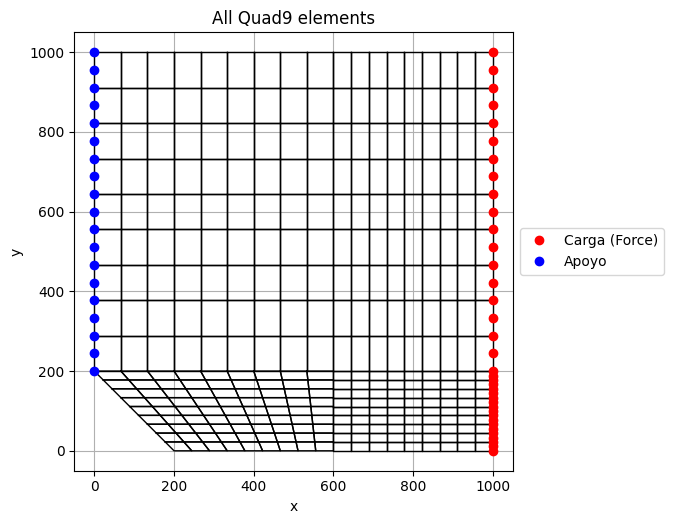

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_elements_quad9(elements, title, show_ids=True, bc_1_nodes=None, bc_r1_nodes=None):
    all_x = []
    all_y = []

    # Recolectamos las coordenadas de todos los elementos
    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Solo usar nodos de esquina para el contorno (0, 1, 2, 3, 0)
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        
        all_x.extend(coords_border[:, 0])
        all_y.extend(coords_border[:, 1])

    # Márgenes y dimensiones
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05

    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin

    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))

    # Recorremos los elementos para dibujar sus contornos
    for elem in elements:
        coords = elem.xy  # coords.shape = (9, 2)
        
        # Dibujar contorno con nodos de esquina
        border_nodes = [0, 1, 2, 3, 0]
        coords_border = np.array([coords[i] for i in border_nodes])
        ax.plot(coords_border[:, 0], coords_border[:, 1], 'k-', linewidth=1)

        # Mostrar los ids de los nodos si se requiere
        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords):
                ax.text(x, y, f'N{nodo.index}', color='black', fontsize=6, ha='center', va='center')

    # Si se pasan los nodos de BC_1, dibujar esos nodos en rojo
    if grupos and "BC_1" in grupos:
        for i, nodo in enumerate(grupos["BC_1"]):
            x, y = nodo.coord
            ax.plot(x, y, 'ro', markersize=6, label="Carga (Force)" if i == 0 else "")

    # Dibujar nodos del grupo "BC_R1" (en azul)
    if grupos and "BC_R1" in grupos:
        for i, nodo in enumerate(grupos["BC_R1"]):
            x, y = nodo.coord
            ax.plot(x, y, 'bo', markersize=6, label="Apoyo" if i == 0 else "")

    # Configurar márgenes y límites del gráfico
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)

    # Agregar leyenda
    ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))  # Poner la leyenda fuera del gráfico

    # Mostrar el gráfico
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajustar el diseño
    plt.show()




plot_all_elements_quad9(
    elements, 
    "All Quad9 elements", 
    show_ids=False, 
    bc_1_nodes=[nodes[0], nodes[1]],  # Ejemplo de nodos para BC_1 (en rojo)
    bc_r1_nodes=[nodes[3], nodes[4]]  # Ejemplo de nodos para BC_R1 (en azul)
)


In [106]:
from solve import Solve

estructure = Solve(used_nodes, elements)

In [107]:
def apply_distributed_force_tri(grupo_nodos, fuerza_total_x, estructura, carga_maxima_arriba=True):
    """
    Aplica una carga distribuida triangular sobre una serie de nodos a lo largo de un tramo de estructura.
    
    Args:
        grupo_nodos (list): Lista de nodos sobre los que aplicar la carga distribuida.
        fuerza_total_x (float): Fuerza total a distribuir en la dirección X.
        estructura (objeto): Estructura donde se aplica la fuerza.
        carga_maxima_arriba (bool): Si True, la carga máxima está en el primer nodo. Si False, en el último nodo.
    """
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar la carga distribuida.")
        return

    # Calcular posiciones acumuladas según distancia entre nodos (longitud sobre la curva)
    posiciones = [0.0]
    for i in range(1, n):
        dx = nodos[i].coord[0] - nodos[i-1].coord[0]
        dy = nodos[i].coord[1] - nodos[i-1].coord[1]
        distancia = np.sqrt(dx**2 + dy**2)
        posiciones.append(posiciones[-1] + distancia)
    total_longitud = posiciones[-1]

    # Inicializar las fuerzas nodales
    nodal_forces = {}

    # Aplicar la distribución triangular de la fuerza
    for i in range(n):
        # Factor triangular, la fuerza es máxima en el extremo si carga_maxima_arriba es True
        if carga_maxima_arriba:
            # Carga máxima en el primer nodo
            fuerza = (fuerza_total_x * (1 - i / (n - 1)))  # El primer nodo recibe la mayor carga
        else:
            # Carga máxima en el último nodo
            fuerza = (fuerza_total_x * (1 - (n - 1 - i) / (n - 1)))  # El último nodo recibe la mayor carga

        nodal_forces[nodos[i].index] = fuerza

    # Aplicar las fuerzas en los nodos
    for node in nodos:
        f = nodal_forces[node.index]
        dof_x, dof_y = node.dofs
        estructura.apply_force(dof_x, f ) #si quieres fuerza en X esto se hace 0
        estructura.apply_force(dof_y, 0.0)  #Si quieres fuerza en Y esto se hace 0
        print(f"Nodo {node.index} ← Fx = {f:.3f} N, Fy = 0.000 N, coordenadas x = {node.coord[0]:.3f}, coordenadas y = {node.coord[1]:.3f}")

# Uso:
nodos_fuerza = grupos["BC_1"]  # O el grupo que corresponda

apply_distributed_force_tri(nodos_fuerza, fuerza_total_x=1000, estructura=estructure, carga_maxima_arriba=True)  # Para carga máxima arriba


Nodo 4 ← Fx = 1000.000 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 0.000
Nodo 61 ← Fx = 972.222 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 22.222
Nodo 69 ← Fx = 944.444 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 11.111
Nodo 62 ← Fx = 916.667 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 44.444
Nodo 70 ← Fx = 888.889 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 33.333
Nodo 63 ← Fx = 861.111 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 66.667
Nodo 71 ← Fx = 833.333 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 55.556
Nodo 64 ← Fx = 805.556 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 88.889
Nodo 72 ← Fx = 777.778 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 77.778
Nodo 65 ← Fx = 750.000 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 111.111
Nodo 73 ← Fx = 722.222 N, Fy = 0.000 N, coordenadas x = 1000.000, coordenadas y = 100.000
Nodo 66 ← Fx = 694.4

In [108]:
def apply_distributed_force_x(grupo_nodos, fuerza_total_x, estructura):
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Calcular posiciones acumuladas según distancia entre nodos (longitud sobre la curva)
    posiciones = [0.0]
    for i in range(1, n):
        dx = nodos[i].coord[0] - nodos[i-1].coord[0]
        dy = nodos[i].coord[1] - nodos[i-1].coord[1]
        distancia = np.sqrt(dx**2 + dy**2)
        posiciones.append(posiciones[-1] + distancia)
    total_longitud = posiciones[-1]

    # Inicializar fuerzas nodales
    nodal_forces = {}

    # Aplicar fuerza proporcional al tramo entre posiciones adyacentes
    for i in range(n):
        if i == 0:
            # Primer nodo: mitad de la diferencia con siguiente nodo
            fuerza = (posiciones[1] - posiciones[0]) / total_longitud * fuerza_total_x * 0.5
        elif i == n-1:
            # Último nodo: mitad de la diferencia con nodo anterior
            fuerza = (posiciones[-1] - posiciones[-2]) / total_longitud * fuerza_total_x * 0.5
        else:
            # Nodo interno: mitad de tramo anterior + mitad de tramo siguiente
            fuerza = ((posiciones[i] - posiciones[i-1]) + (posiciones[i+1] - posiciones[i])) / total_longitud * fuerza_total_x * 0.5
        nodal_forces[nodos[i].index] = fuerza

    # Aplicar fuerzas en X
    for node in nodos:
        fx = nodal_forces[node.index]
        dof_x, dof_y = node.dofs
        estructura.apply_force(dof_x, fx)
        estructura.apply_force(dof_y, 0.0)
        print(f"Nodo {node.index} ← Fx = {fx:.3f} N, Fy = 0.000 N, coordenadas x = {node.coord[0]:.3f}, coordenadas y = {node.coord[1]:.3f}")

#nodos_fuerza = grupos["BC_1"]  # O el grupo que corresponda
#apply_distributed_force_x(nodos_fuerza, fuerza_total_x=100000, estructura=estructure)

In [109]:

u = estructure.solve()

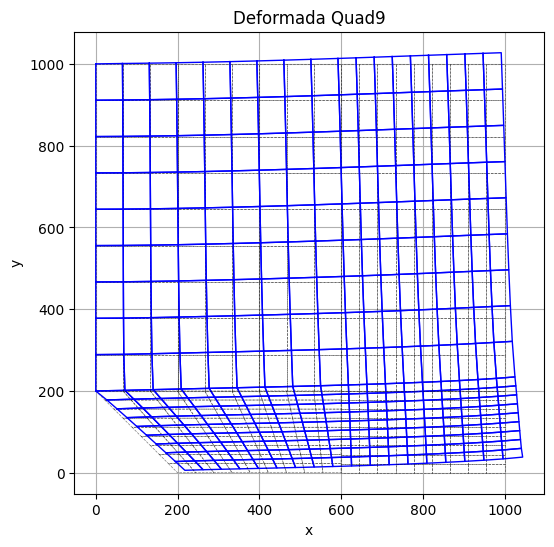

In [110]:
def plot_deformed_structure_quad9(elements, u_global, scale=1.0, show_original=True, title="Deformada"):
    """
    Grafica la estructura deformada para elementos Quad9.

    Args:
        elements (list): Lista de elementos Quad9.
        u_global (ndarray): Vector global de desplazamientos.
        scale (float): Factor de escala para deformación visual.
        show_original (bool): Muestra la geometría original si es True.
        title (str): Título del gráfico.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')

    for elem in elements:
        xy = elem.xy  # (9, 2)
        # Contorno sólo con nodos esquina (0,1,2,3,0)
        corner_indices = [0, 1, 2, 3, 0]
        coords = xy[corner_indices]

        if show_original:
            ax.plot(coords[:, 0], coords[:, 1], 'k--', linewidth=0.5, alpha=0.5)

        idx = elem.calculate_indices()
        u_elem = u_global[idx].flatten()
        xy_def = xy + scale * u_elem.reshape(-1, 2)
        coords_def = xy_def[corner_indices]

        ax.plot(coords_def[:, 0], coords_def[:, 1], 'b-', linewidth=1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)
    plt.show()

# Uso:
plot_deformed_structure_quad9(elements, u, scale=1e4, show_original=True, title="Deformada Quad9")

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_stress_strain_components(elements, u):
    results = []
    for elem in elements:
        sigma = elem.get_stress(u)  # σxx, σyy, σxy
        epsilon = elem.get_strain(u)  # εxx, εyy, εxy
        exx, eyy, exy = epsilon
        sxx, syy, sxy = sigma

        avg_eps = 0.5 * (exx + eyy)
        rad_eps = np.sqrt(((exx - eyy) / 2) ** 2 + exy ** 2)
        eps1 = avg_eps + rad_eps
        eps2 = avg_eps - rad_eps

        avg_sig = 0.5 * (sxx + syy)
        rad_sig = np.sqrt(((sxx - syy) / 2) ** 2 + sxy ** 2)
        sig1 = avg_sig + rad_sig
        sig2 = avg_sig - rad_sig

        results.append({
            "element": elem.elementTag,
            "σxx": sxx, "σyy": syy, "σxy": sxy,
            "εxx": exx, "εyy": eyy, "εxy": exy,
            "σ1": sig1, "σ2": sig2,
            "ε1": eps1, "ε2": eps2
        })
    return results

def ensure_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def average_element_values_to_nodes(nodes, elements, element_values):
    from collections import defaultdict
    val_sum = defaultdict(float)
    val_count = defaultdict(int)
    for elem, val in zip(elements, element_values):
        for node in elem.node_list:
            val_sum[node.name] += val
            val_count[node.name] += 1
    node_id_to_avg = {
        nid: val_sum[nid] / val_count[nid] for nid in val_sum
    }
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    nodal_values = np.array([
        node_id_to_avg[node.name] for node in nodes
    ])
    return nodal_values

def quad4_to_triangles(elements, node_id_to_index):
    triangles = []
    for elem in elements:
        ids = [node_id_to_index[n.name] for n in elem.node_list]
        triangles.append([ids[0], ids[1], ids[2]])
        triangles.append([ids[0], ids[2], ids[3]])
    return triangles

def plot_scalar_field_on_mesh(nodes, elements, values, title, folder="figuras", filename=None, cmap="viridis"):
    import matplotlib.tri as mtri
    ensure_dir(folder)
    
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    xs = np.array([node.coord[0] for node in nodes])
    ys = np.array([node.coord[1] for node in nodes])
    nodal_values = np.array(values)
    triangles = quad4_to_triangles(elements, node_id_to_index)
    triang = mtri.Triangulation(xs, ys, triangles)

    # Márgenes automáticos
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05
    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin
    fixed_width = 8
    height = fixed_width * (y_range / x_range)

    fig, ax = plt.subplots(figsize=(fixed_width, height))
    tcf = ax.tricontourf(triang, nodal_values, levels=20, cmap=cmap)

    cbar = fig.colorbar(tcf, ax=ax)
    cbar.set_label(title)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect("equal", adjustable='box')
    ax.grid(True)
    plt.tight_layout()

    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()

def plot_all_fields(results, nodes, elements, i):
    fields = ["\u03c3xx", "\u03c3yy", "\u03c3xy", "\u03c31", "\u03c32", "\u03b5xx", "\u03b5yy", "\u03b5xy", "\u03b51", "\u03b52"]
    titles = {
        "\u03c3xx": "Stress σxx", "\u03c3yy": "Stress σyy", "\u03c3xy": "Stress σxy",
        "\u03c31": "Maximum Principal Stress σ1", "\u03c32": "Minimum Principal Stress σ2",
        "\u03b5xx": "Strain εxx", "\u03b5yy": "Strain εyy", "\u03b5xy": "Strain εxy",
        "\u03b51": "Maximum Principal Strain ε1", "\u03b52": "Minimum Principal Strain ε2"
    }
    caso = str(i)  # Usamos el índice del caso para el título
    for field in fields:
        element_values = [res[field] for res in results]
        nodal_values = average_element_values_to_nodes(nodes, elements, element_values)
        plot_scalar_field_on_mesh(nodes, elements, nodal_values, f"{caso} — {titles[field]}", folder="Resultados")


In [112]:
results = compute_stress_strain_components(elements, u)
plot_all_fields(results, used_nodes, elements, i)